Data Preprocessing

In [6]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import cv2

def parse_annotation(annotation_line):
    parts = annotation_line.strip().split()
    class_id = int(parts[0])  # The class_id is the first element
    vertices = np.array(parts[1:], dtype=np.float32)  # The rest are the vertices
    return class_id, vertices.reshape((-1, 2))  # Reshape to Nx2 where N is the number of vertices

def draw_polygon_on_mask(mask, corners, image_shape):
    scaled_corners = corners * np.array([image_shape[1], image_shape[0]], dtype=np.float32)  # scale x and y
    scaled_corners = np.around(scaled_corners).astype(np.int32)  # round and convert to int

    # print("Scaled Corners:", scaled_corners)  # Debugging print

    corners_int = scaled_corners.reshape((-1, 1, 2))
    cv2.fillPoly(mask, [corners_int], color=(255))  # Ensure fillPoly is used, not polylines

    # # Debugging visualization
    # plt.imshow(mask, cmap='gray')
    # plt.title('Polygon on Mask')
    # plt.axis('off')
    # plt.show()

def create_mask_from_annotations(annotation_path, image_shape):
    mask = np.zeros((image_shape[0], image_shape[1]), dtype=np.uint8)  # Create a black mask
    with open(annotation_path, 'r') as file:
        for line in file:
            class_id, vertices = parse_annotation(line)
            draw_polygon_on_mask(mask, vertices, image_shape)  # Draw each polygon on the mask
    return mask

def preprocess_image(image_path, annotation_path, target_size):
    # Open and resize image
    image = Image.open(image_path).resize(target_size)
    mask = create_mask_from_annotations(annotation_path, target_size)  # Note the reversal of width and height for the mask
    return np.array(image), mask

def process_directory(data_dir, annotation_dir, target_size):
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            # plt.imshow(mask, cmap='gray')  # Debugging visualization
            # plt.show()
            
def save_as_npy(data_dir, annotation_dir, target_size=(512, 512)):
    processed_data = []
    for img_filename in os.listdir(data_dir):
        if img_filename.endswith('.jpg'):
            image_path = os.path.join(data_dir, img_filename)
            annotation_path = os.path.join(annotation_dir, img_filename.replace('.jpg', '.txt'))
            image, mask = preprocess_image(image_path, annotation_path, target_size)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_img.npy')), image)
            np.save(os.path.join(data_dir, img_filename.replace('.jpg', '_mask.npy')), mask)
            processed_data.append((image, mask))
    print(f"Processed and saved {len(processed_data)} image-mask pairs in .npy format.")

# Example usage
dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (512, 512)  # Change as required by your model

# Process images and annotations and save them as .npy files
# Process images and annotations
for part in partitions:
    images_dir = os.path.join(dataset_base, part, 'images')
    annotations_dir = os.path.join(dataset_base, part, 'labels')
    process_directory(images_dir, annotations_dir, target_size)
    print(f"Finished processing {part} set")

# Visualization (example for one image from the 'train' set)
train_images_dir = os.path.join(dataset_base, 'train', 'images')
train_image_files = [f for f in os.listdir(train_images_dir) if f.endswith('_img.npy')]

# Load one image and its corresponding mask
image = np.load(os.path.join(train_images_dir, train_image_files[0]))
mask = np.load(os.path.join(train_images_dir, train_image_files[0].replace('_img.npy', '_mask.npy')))

# # Visualize the image and the mask
# plt.figure(figsize=(12, 6))
# plt.subplot(1, 2, 1)
# plt.imshow(image)
# plt.title('Processed Image')
# plt.axis('off')
# 
# plt.subplot(1, 2, 2)
# plt.imshow(mask, cmap='gray')
# plt.title('Processed Mask')
# plt.axis('off')
# 
# plt.show()



Finished processing train set
Finished processing valid set
Finished processing test set


Semantics CNN

Found 8691 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\train\images
Found 2483 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\valid\images
Found 1242 images in directory C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb\test\images
Epoch 1, Validation Loss: 0.4072, Validation Accuracy: 0.8057
Epoch 2, Validation Loss: 0.3733, Validation Accuracy: 0.8300
Epoch 3, Validation Loss: 0.2805, Validation Accuracy: 0.8809
Epoch 4, Validation Loss: 0.2357, Validation Accuracy: 0.9020
Epoch 5, Validation Loss: 0.2123, Validation Accuracy: 0.9141
Epoch 6, Validation Loss: 0.1920, Validation Accuracy: 0.9218
Epoch 7, Validation Loss: 0.1676, Validation Accuracy: 0.9327
Epoch 8, Validation Loss: 0.1621, Validation Accuracy: 0.9350
Epoch 9, Validation Loss: 0.1653, 

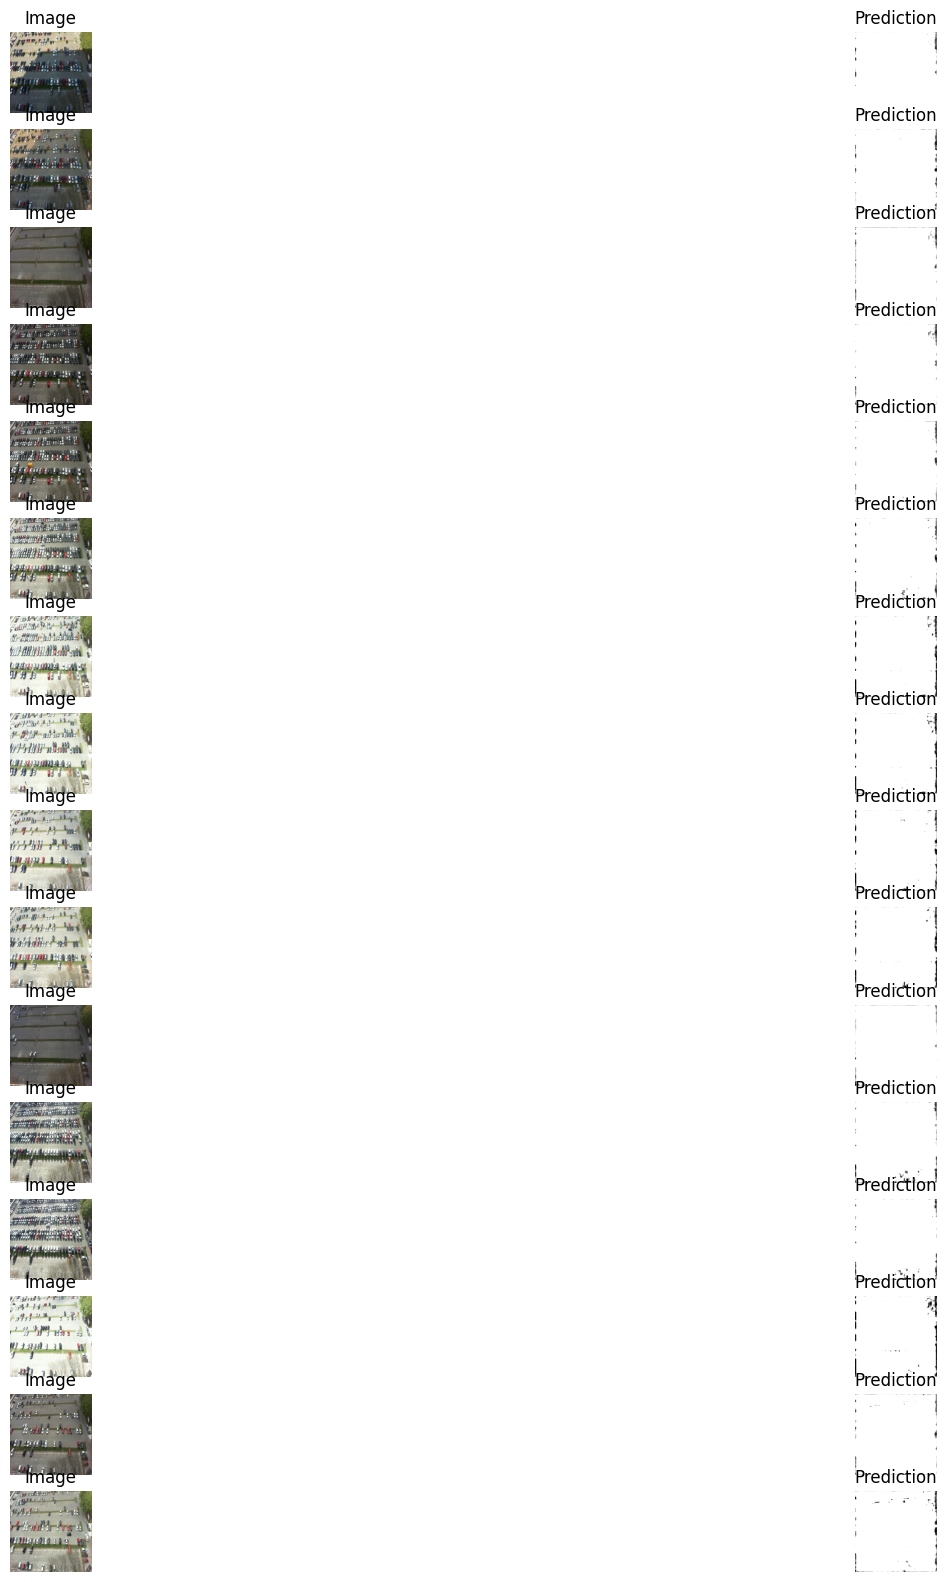

In [14]:
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2

# Define the CNN architecture for segmentation
class SegmentationModel(nn.Module):
    def __init__(self):
        super(SegmentationModel, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()  # Use sigmoid for binary segmentation
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

class PKLotDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('_img.npy')]
        self.transform = transform
        print(f"Found {len(self.image_files)} images in directory {data_dir}")  # Debugging output

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        image_file = os.path.join(self.data_dir, self.image_files[idx])
        mask_file = image_file.replace('_img.npy', '_mask.npy')

        image = np.load(image_file)
        mask = np.load(mask_file)
        
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

# Define the evaluation function
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            loss = criterion(outputs, masks)
            preds = outputs > 0.5
            total_loss += loss.item() * images.size(0)
            total_correct += preds.eq(masks).sum().item()
            total_pixels += masks.numel()

    average_loss = total_loss / len(loader.dataset)
    accuracy = total_correct / total_pixels
    return average_loss, accuracy

dataset_base = r'C:/Users/SirM/Desktop/Swayam/Intro to Deep Learning/Intro-to-Deep-Learning/Final Project/PKLot.v1-raw.yolov8-obb'
partitions = ['train', 'valid', 'test']
target_size = (256, 256)


# Create datasets and dataloaders for train, validation, and test sets
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = PKLotDataset(os.path.join(dataset_base, 'train', 'images'), transform=transform)
valid_dataset = PKLotDataset(os.path.join(dataset_base, 'valid', 'images'), transform=transform)
test_dataset = PKLotDataset(os.path.join(dataset_base, 'test', 'images'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Setup device, model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SegmentationModel().to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def calculate_accuracy(outputs, masks, threshold=0.5):
    # Apply sigmoid to get probabilities
    probs = torch.sigmoid(outputs)
    # Apply threshold to get binary tensor
    preds = (probs > threshold).float()
    # Calculate accuracy
    correct = (preds == masks).float()
    accuracy = correct.sum() / correct.numel()
    return accuracy.item()

# Initialize lists to store accuracies for each batch
accuracies = []

# Training loop
for epoch in range(10):
    model.train()
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
    
    # Evaluate on validation data
    val_loss, val_accuracy = evaluate(model, valid_loader, criterion, device)
    print(f"Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

# Save the trained model
torch.save(model.state_dict(), 'segmentation_model.pth')

# Load the trained model for testing
model.load_state_dict(torch.load('segmentation_model.pth'))
model.to(device)

# Evaluate on test data
test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")
    

def visualize_predictions(model, loader, device, threshold=0.5):
    model.eval()
    with torch.no_grad():
        for images, masks in loader:
            images = images.to(device)
            outputs = model(images)
            probs = torch.sigmoid(outputs)
            preds = (probs > threshold).float()

            # Move to CPU for visualization
            images = images.cpu()
            preds = preds.cpu()

            plt.figure(figsize=(1, 1))
            for idx in range(len(images)):
                plt.subplot(len(images), 2, 2 * idx + 1)
                plt.imshow(images[idx].permute(1, 2, 0))
                plt.title("Image")
                plt.axis('off')

                plt.subplot(len(images), 2, 2 * idx + 2)
                plt.imshow(preds[idx].squeeze(), cmap='gray')
                plt.title("Prediction")
                plt.axis('off')
            plt.show()
            break  # Only show 1 batch

# Visualize the model's predictions on the test set
visualize_predictions(model, test_loader, device)


In [74]:
import os
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import torch
import torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

    
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()
        self.encoder1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.encoder2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        # ... add more layers as needed
        self.decoder1 = DoubleConv(128, 64)
        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        # ... add more layers as needed
        self.final_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        enc1 = self.encoder1(x)
        x = self.pool1(enc1)
        enc2 = self.encoder2(x)
        x = self.pool2(enc2)
        # ... continue forward pass
        # Decoder
        x = self.up1(x)
        x = torch.cat((x, enc2), dim=1)
        x = self.decoder1(x)
        # ... continue forward pass
        x = self.final_conv(x)
        return torch.sigmoid(x)

model = UNet().to(device)



cuda


RuntimeError: Given transposed=1, weight of size [256, 128, 2, 2], expected input[8, 128, 11, 11] to have 256 channels, but got 128 channels instead